In [126]:
import datetime
import pandas
import seaborn as sns
from davitpy import pydarn
from davitpy import gme
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.dates import date2num, DateFormatter, MinuteLocator
from matplotlib.ticker import FuncFormatter, MaxNLocator
import numpy as np
from scipy.signal import medfilt2d
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Plotting TEC Maps

The format of the tec-medFilt-YYYYMMDD.txt is as follows:
1. First column is date in YYYYMMDD format
2. Second column is time in hhmm format where hh is hour and mm is minutes. If the value is 10 then it means 0010 (00:10 mins).
3. Third column represents the magnetic latitude values
4. Fourth column represents the magnetic longitude values
5. Fifth column represents the actual TEC (total electron content) values
6. Sixth and seventh columns represent the degree of latitude and longitude

In [2]:
# function to convert tec date, time string to python datetime obj
def convert_to_datetime(row):
    currDateStr = str( int( row["dateStr"] ) )
    if row["timeStr"] < 10:
        currTimeStr = "000" + str( int( row["timeStr"] ) )
    elif row["timeStr"] < 100:
        currTimeStr = "00" + str( int( row["timeStr"] ) )
    elif row["timeStr"] < 1000:
        currTimeStr = "0" + str( int( row["timeStr"] ) )
    else:
        currTimeStr = str( int( row["timeStr"] ) )  
    #print datetime.datetime.strptime( currDateStr+ ":" + currTimeStr, "%Y%m%d:%H%M" )
    return datetime.datetime.strptime( currDateStr+ ":" + currTimeStr, "%Y%m%d:%H%M" )

In [4]:
#loading the TEC data into pandas dataframe
#initializing the columns in the table
inpColList = [ "dateStr", "timeStr", "Mlat", "Mlon", "med_tec", "dlat", "dlon" ]
inpFile = "/home/sneha/GSoC_2018/SpaceVT/dataset/med_filt_tec/tec-medFilt-20150101.txt"
medFiltTECDF = pandas.read_csv(inpFile, delim_whitespace=True, header=None, names=inpColList)
medFiltTECDF["date"] = medFiltTECDF.apply(convert_to_datetime, axis=1)

In [5]:
#selecting the longitudes in the north-american sector
longitudes = list(range(250, 362, 2)) + list(range(0, 35, 2))
print longitudes
#selecting only those rows whose longitudes is in the range of north-american sector
selectedmedFiltTECDF = medFiltTECDF[medFiltTECDF["Mlon"].isin(longitudes)]
#printing the shape of the selected rows
print selectedmedFiltTECDF.shape
#total shape of the TEC file
print medFiltTECDF.shape

[250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34]
(897994, 8)
(2038395, 8)


In [89]:
date_val = ["15", "25", "30", "45", "55", "60", "75", "85", "90", "105", "115", "120", "135", "145", "150", "165", "175", "180", "195", "200", "210", "225", "230"]
#initializing the datetime variable which will be used for selecting values from the table
date = datetime.datetime.strptime( "20150101"+ ":" + "230", "%Y%m%d:%H%M" )
#selecting those rows where the datetime gives the time with the longitudes are in the given range and latitude = 11
print selectedmedFiltTECDF[(medFiltTECDF["Mlat"]==11.00) & (medFiltTECDF["date"]==date)]

          dateStr  timeStr  Mlat   Mlon  med_tec  dlat  dlon  \
1948060  20150101     2300  11.0    0.0     39.3   1.0   2.0   
1948061  20150101     2300  11.0    2.0     39.6   1.0   2.0   
1948062  20150101     2300  11.0    4.0     39.4   1.0   2.0   
1948063  20150101     2300  11.0    6.0     38.3   1.0   2.0   
1948064  20150101     2300  11.0    8.0     34.6   1.0   2.0   
1948065  20150101     2300  11.0   10.0     31.5   1.0   2.0   
1948066  20150101     2300  11.0   12.0     26.9   1.0   2.0   
1948067  20150101     2300  11.0   14.0     23.9   1.0   2.0   
1948068  20150101     2300  11.0   16.0     20.7   1.0   2.0   
1948069  20150101     2300  11.0   18.0     19.3   1.0   2.0   
1948070  20150101     2300  11.0   20.0     19.1   1.0   2.0   
1948071  20150101     2300  11.0   22.0     19.8   1.0   2.0   
1948072  20150101     2300  11.0   24.0     16.6   1.0   2.0   
1948073  20150101     2300  11.0   26.0     15.6   1.0   2.0   
1948074  20150101     2300  11.0   28.0 

In [146]:
#populating the TEC maps in a matrix format. The rows corresponds to latitudes and columns corresponds to longitudes
#Number of latitdues = (89-11) + 1 = 79, number of longitudes = (34-0)/2 + (360-250)/2 + 1 = 73. (number of longitudes is divided by 2 as the degree of longitudes is 2)
#values in the TEC maps are stored from (250 to 360) then (0 to 34)
longi = list(range(0, 35, 2))
tec_maps = []
for j in date_val:
    date = datetime.datetime.strptime( "20150101"+ ":" + j, "%Y%m%d:%H%M" )
    print date
    #selecting those rows where the datetime gives the time with the longitudes are in the given range and latitude = 11
    check_tec_map = medFiltTECDF[(medFiltTECDF["date"]==date)]
    if(len(check_tec_map) > 0):
        tec2d = np.empty((75,73))
        tec2d.fill(-1)
        for i in range(0, 75):
            selected = selectedmedFiltTECDF[(medFiltTECDF["Mlat"]==i+15) & (medFiltTECDF["date"]==date)]
            tec = []
            for index, row in selected.iterrows():
                if(int(row["Mlon"]) in longi):
                    j = int(row["Mlon"])/2 + 55
                else:
                    j = ((int(row["Mlon"]) - 250)/2)
                tec2d[i][j] = float(row["med_tec"])
        #print tec2d.shape         
        tec_maps.append(tec2d)      

2015-01-01 01:05:00
2015-01-01 02:05:00
2015-01-01 03:00:00
2015-01-01 04:05:00
2015-01-01 05:05:00
2015-01-01 06:00:00
2015-01-01 07:05:00
2015-01-01 08:05:00
2015-01-01 09:00:00
2015-01-01 10:05:00
2015-01-01 11:05:00
2015-01-01 12:00:00
2015-01-01 13:05:00
2015-01-01 14:05:00
2015-01-01 15:00:00
2015-01-01 16:05:00
2015-01-01 17:05:00
2015-01-01 18:00:00
2015-01-01 19:05:00
2015-01-01 20:00:00
2015-01-01 21:00:00
2015-01-01 22:05:00
2015-01-01 23:00:00


In [147]:
tec_maps = np.array(tec_maps)
print tec_maps.shape  
#masking the -1 value in the tec2d
tec_maps_masked = np.ma.masked_where(tec_maps <= -1, tec_maps)
min_val = np.min(tec_maps_masked)
max_val = np.max(tec_maps_masked)
print np.min(tec_maps_masked)
print np.max(tec_maps_masked)

(23, 75, 73)
0.0
92.9


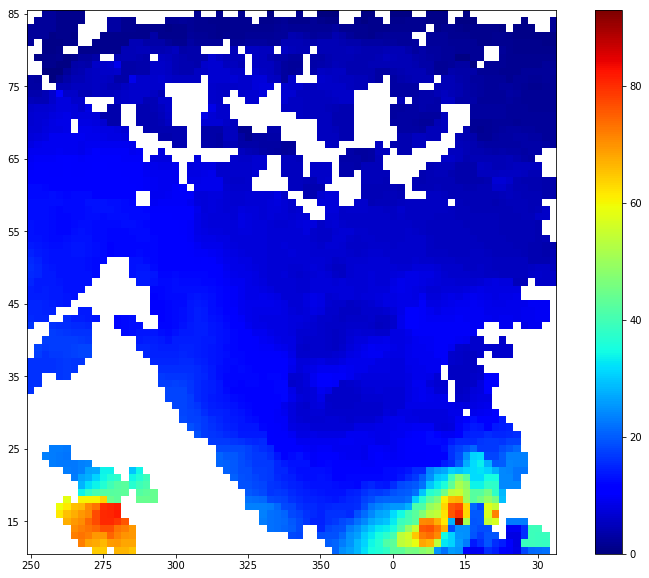

In [148]:
#Flipping the matrix to get the low latitude value at the bottom
tec2d_inv = np.flipud(tec_maps_masked[0])
#plotting the TEC map 
fig, ax = plt.subplots(1,1, figsize=(14, 10))
x = list(range(225, 360, 25)) + list(range(0, 35, 15)) 
y = list(range(15, 100, 10))
ax.set_xticklabels(tuple(x))
ax.set_yticklabels(y[::-1])
plt.imshow(tec2d_inv, cmap='jet', interpolation='nearest', vmin=min_val, vmax=max_val)
plt.colorbar()
fig.savefig(str(0)+'.png', dpi=fig.dpi)
#plt.show()

In [154]:
print type(tec2d_inv)
tec2d_filtered = medfilt2d(tec2d_inv, 7)
print np.min(tec2d_filtered)
tec2d_filt_masked = np.ma.masked_where(tec2d_filtered <= -1, tec2d_filtered)

<class 'numpy.ma.core.MaskedArray'>
-1.0


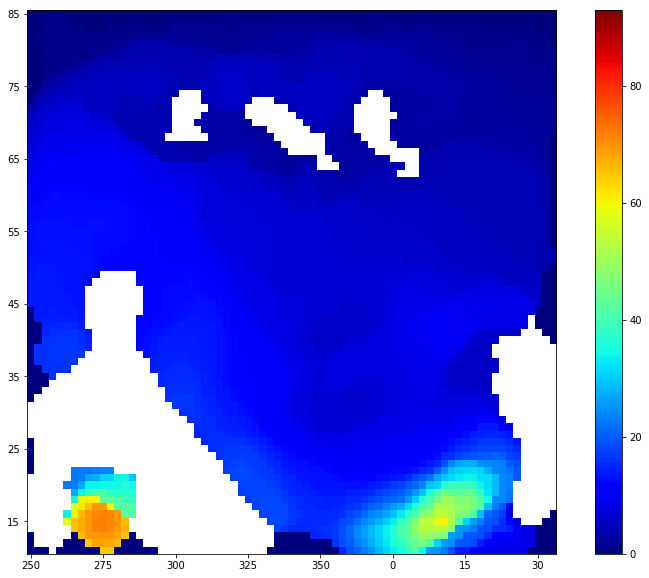

In [155]:
#plotting the TEC map 
fig, ax = plt.subplots(1,1, figsize=(14, 10))
x = list(range(225, 360, 25)) + list(range(0, 35, 15)) 
y = list(range(15, 100, 10))
ax.set_xticklabels(tuple(x))
ax.set_yticklabels(y[::-1])
plt.imshow(tec2d_filt_masked, cmap='jet', interpolation='nearest', vmin=min_val, vmax=max_val)
plt.colorbar()
fig.savefig('filter7.png', dpi=fig.dpi)
#plt.show()

In [143]:
#command to take the plots and convert it into a movie
import os
os.system("ffmpeg -r 1 -i img%01d.png -vcodec mpeg4 -y movie.mp4")

256